Following this guide for understanding and building: https://www.youtube.com/watch?v=TCH_1BHY58I

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [42]:
# Loading in data 
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [43]:
chars = sorted(list(set(''.join(words)))) # Get all possible letters 
# Apply index based mapping
stoi = {char:i+1 for i,char in enumerate(chars)}
stoi['.'] = 0
itos = {i:char for char, i in stoi.items()}
vocab_size = len(itos)

In [71]:
# Build dataset 
block_size = 3

def build_dataset(words): 
    x=[]
    y=[]

    for word in words:
        context = [0] * block_size

        for char in word + '.': #need to add ending indicator
            index = stoi[char]
            #print(context)
            x.append(context)
            y.append(index)
            #print(''.join(itos[i] for i in context), '----->', itos[y[-1]])
            context = context[1:] + [index]
    x = torch.tensor(x)
    y = torch.tensor(y)
    return x, y 

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

xtr, ytr = build_dataset(words[:n1])
xval, yval = build_dataset(words[n1:n2])
xtest,ytest = build_dataset(words[n2:])

In [72]:
#MLP Revisited 
n_embed = 10 #number of embeddings 
n_hidden = 200 # number of neurons in hidden layer 

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed),              generator = g)
W1 = torch.randn((n_embed * block_size, n_hidden),  generator = g)
b1 = torch.randn((n_hidden),                        generator = g)
W2 = torch.randn((n_hidden, vocab_size),            generator = g)
b2 = torch.randn((vocab_size),                      generator = g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


11897


In [73]:
# Batch Training
batch_size = 32
training_iters = 200000
lossi = []

for i in range(training_iters):
    ix = torch.randint(0,xtr.shape[0], (batch_size,))
    xb, yb = xtr[ix], ytr[ix]

    emb = C[xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
      # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{training_iters:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 26.7189
  10000/ 200000: 2.6191
  20000/ 200000: 2.9194
  30000/ 200000: 2.6206
  40000/ 200000: 2.1360
  50000/ 200000: 2.3207
  60000/ 200000: 2.2866
  70000/ 200000: 2.4830
  80000/ 200000: 2.5367
  90000/ 200000: 2.4002
 100000/ 200000: 2.0727
 110000/ 200000: 2.2361
 120000/ 200000: 2.0168
 130000/ 200000: 2.6164
 140000/ 200000: 2.3628
 150000/ 200000: 2.1042
 160000/ 200000: 1.9215
 170000/ 200000: 1.9828
 180000/ 200000: 2.6498
 190000/ 200000: 2.0295


#### Fixing High Loss thorugh Proper Initialization 

See the obvious problem here? The first few thousand of iterations are wasted on trying to get the network to a lower reasonable state, since the network is confidently wrong. On a small network like this one, it isn't a problem, but if instead the network were in a state of near zero initialization, the network would be in a much more ready state to learn. 

Assuming equal probability the expected loss should be -torch.tensor(1/27).log() = 3.2958 which is significantly lower than 26.7189 

So how do we go about reducing the inital loss? Adjust the randomly initalized parameters!

Below, training is stopped after a single iteration to show the new loss of the adjusted parameters with loss being 3.3055.

Bias is a parameter that is learned can be set to a matrix of zeros and by adjust the W2 matrix to near zero, the initial training loss is reduced further. It is important to have it near zero so the system has some entropy to introducing symmetry breaking. 

In [91]:
#MLP Revisited 
n_embed = 10 #number of embeddings 
n_hidden = 200 # number of neurons in hidden layer 

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed),              generator = g)
W1 = torch.randn((n_embed * block_size, n_hidden),  generator = g)
b1 = torch.randn((n_hidden),                        generator = g)
W2 = torch.randn((n_hidden, vocab_size),            generator = g) * 0.01
b2 = torch.randn((vocab_size),                      generator = g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
# Batch Training
batch_size = 32
training_iters = 200000
lossi = []

for i in range(training_iters):
    ix = torch.randint(0,xtr.shape[0], (batch_size,))
    xb, yb = xtr[ix], ytr[ix]

    emb = C[xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
      # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{training_iters:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break 

11897
      0/ 200000: 3.2846


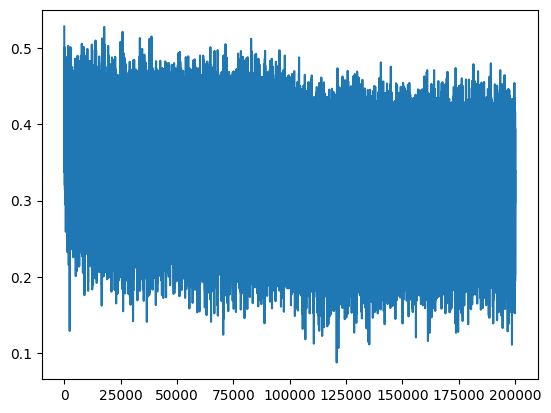

In [79]:
plt.plot(lossi) # No more hockey stick since the initialization isnt trash anymore

#### Fixing the activation function distribution:

The loss is "fixed" at initialization, but deeper problems lie within the intialization of the network. Becasue of the bounds of the activation function where tanh(x>2) ≈ 1 and tanh(x<-2) ≈ -1, during backprop of the tanh function, the gradient effectively gets zero'd out meaning there will be no updates to this node. During input, there are 32 (batchsize) potential inputs that all produce some unique acivation function gradients ranging from -1 to 1 for each of the 200 different neurons. If all the activation functions for a node reach either 1,-1, then the node is dead and cannot learn regardless of the input. 

##### Make sure to inspect activation values at instantiation so ya bois can learn!!!

How to fix: Balance inital weight and bias matrix as well to ensure that confidently wrong values aren't present 

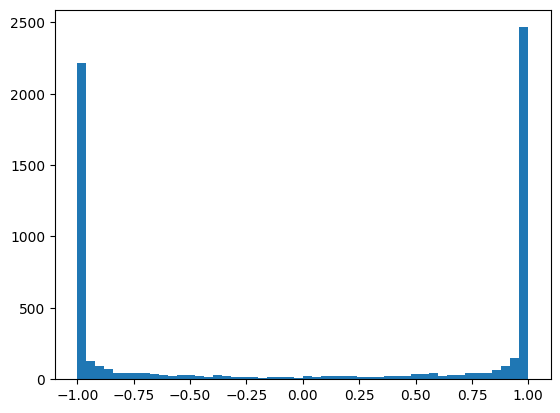

In [82]:
plt.hist(h.view(-1).tolist(), 50);
# Like I said, this is extremely bad to see since the leanring happens in the middle

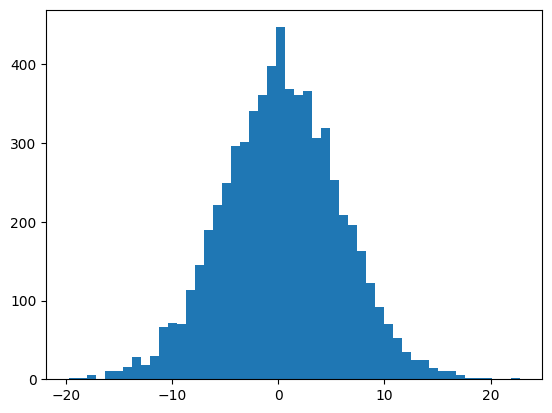

In [92]:
plt.hist(hpreact.view(-1).tolist(), 50);
# Way too many extreme values sitting past 2,-2

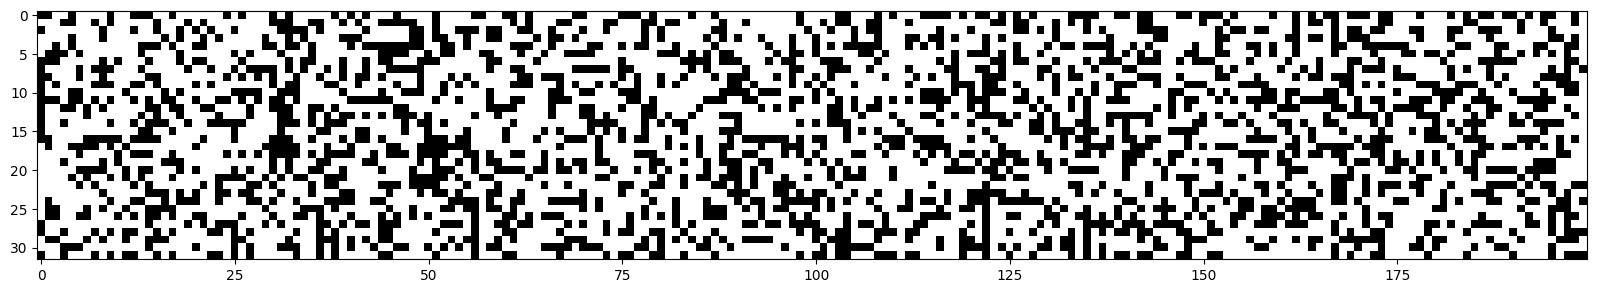

In [86]:
# Taking a closer look to see if there are infact any dead neurons, but keep in mind that the white ones are either not learning or are learning VERY slowly
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

After training results:

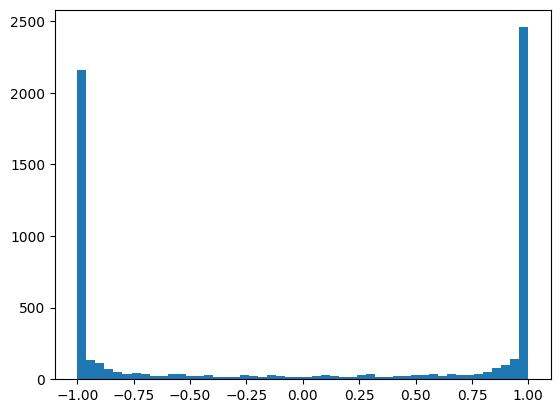

In [93]:
plt.hist(h.view(-1).tolist(), 50);

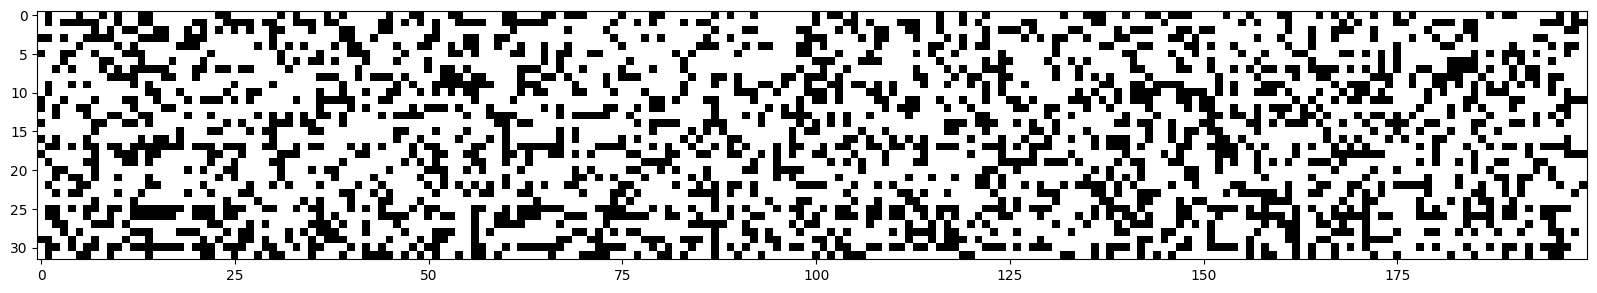

In [89]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [99]:
#MLP Revisited 
n_embed = 10 #number of embeddings 
n_hidden = 200 # number of neurons in hidden layer 

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed),              generator = g)
W1 = torch.randn((n_embed * block_size, n_hidden),  generator = g) * 0.2 # 
b1 = torch.randn((n_hidden),                        generator = g) * 0.01 # this one isn't zero, to have just some variation/entropy in system 
W2 = torch.randn((n_hidden, vocab_size),            generator = g) * 0.01
b2 = torch.randn((vocab_size),                      generator = g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
# Batch Training
batch_size = 32
training_iters = 200000
lossi = []

for i in range(training_iters):
    ix = torch.randint(0,xtr.shape[0], (batch_size,))
    xb, yb = xtr[ix], ytr[ix]

    emb = C[xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
      # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{training_iters:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break 

11897
      0/ 200000: 3.3042


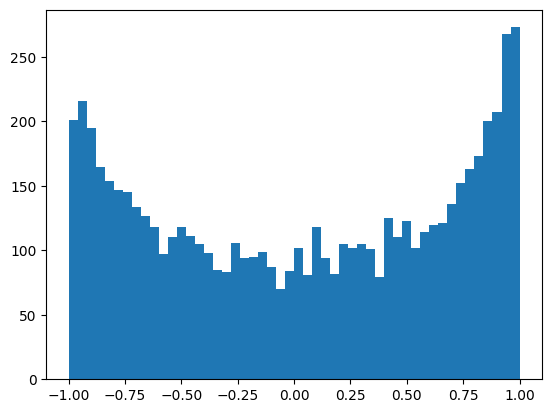

In [100]:
plt.hist(h.view(-1).tolist(), 50);
# activation function looks much cleaner and ready to learn 

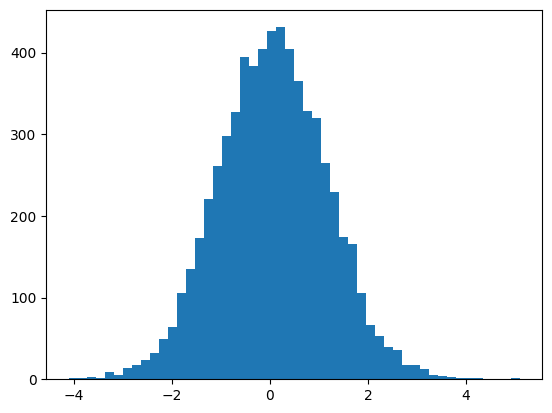

In [101]:
plt.hist(hpreact.view(-1).tolist(), 50);
# An obvious direct result of setting the weights to reasonable bounds 

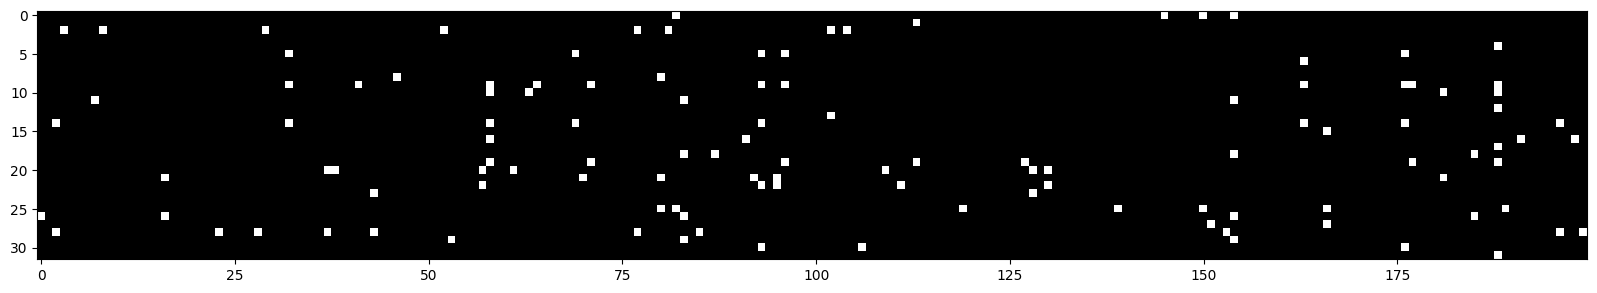

In [103]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') #you want some white 

#### Dealing with matrix multiplication resulting in larger varience and values:

When the NN is progressing through the layers, the inevitable multiplication of the the previously activated layer (hpreact) and the current weights (W2) will lead to the mean staying the same, but the varience increases. And so do the values, leading to the problem that was being faced before, where these values are not well bounded and can lead to increasingly large values that make it impossible for the NN to learn through back propigation. Exemplified below is the multiplcation of two normal distributions leading to a gain fo 3x for the varience.

The fix: 
- Kaiming initialization (divide matrix by $\sqrt{fanin}$) where fan_in == the number of inner layers being multiplied by (in the example below, this would be 10) and for tanh there is also a gain of 5/3 that needs to be multiplied in as well
    - Some intuition around gain is that since tanh is squashing everything to be between -1,1, there needs to be some pushback to get the varience to behave to return to 1 
    - As well, when you apply this scaling function to keep mean at 0 and varience at 1, the backprop is also well behaved 
- Residual connections (used in GRUs and LSTMs) will be covered later 
- Layer normalization techniques:
    - Batch Norm
    - Layer normalization
    - Group normalization
- Better optimizers (than SGD)
    - RMSProp
    - ADAM (RMSProp + momentum)

Something I want to mention is that there is still some kind of weight initalization that happens at the beginning even with all the other methods applied that is directly decided by the type of activation function later used. 

tensor(0.0105) tensor(1.0164)
tensor(-0.0071) tensor(0.3180)
tensor(-0.0027) tensor(1.0178)


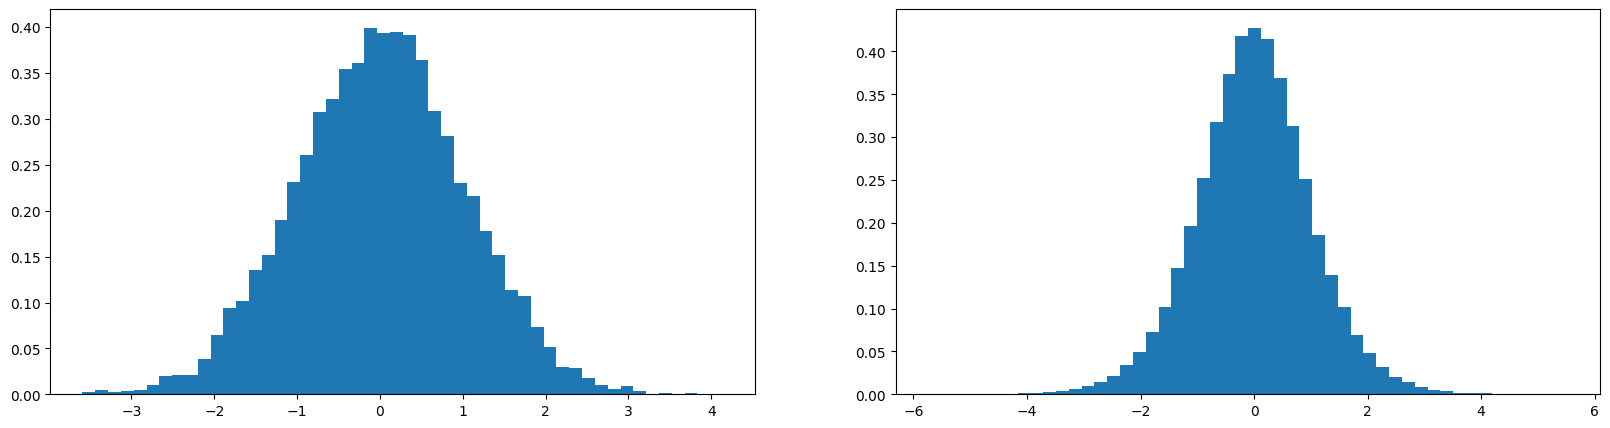

In [109]:
x = torch.randn(1000,10)
w = torch.randn(10,200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(w.mean(), w.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);
# So despite the two normal distributions being well behaved, the varience still finds a way to increase 3x which leads to the high amount of values finding themselevs at the tails. 

In [111]:
# Using the kaiming init method 
n_embed = 10 #number of embeddings 
n_hidden = 200 # number of neurons in hidden layer 

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed),              generator = g)
W1 = torch.randn((n_embed * block_size, n_hidden),  generator = g) * (5/3)/((n_embed * block_size)**0.5) #kaiming init method
b1 = torch.randn((n_hidden),                        generator = g) * 0.01 # this one isn't zero, to have just some variation/entropy in system 
W2 = torch.randn((n_hidden, vocab_size),            generator = g) * 0.01
b2 = torch.randn((vocab_size),                      generator = g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
# Batch Training
batch_size = 32
training_iters = 200000
lossi = []

for i in range(training_iters):
    ix = torch.randint(0,xtr.shape[0], (batch_size,))
    xb, yb = xtr[ix], ytr[ix]

    emb = C[xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
      # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{training_iters:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

11897
      0/ 200000: 3.2902
  10000/ 200000: 2.1222
  20000/ 200000: 2.1223
  30000/ 200000: 2.2104
  40000/ 200000: 2.1326
  50000/ 200000: 2.1810
  60000/ 200000: 2.0915
  70000/ 200000: 2.0586
  80000/ 200000: 2.6180
  90000/ 200000: 1.7655
 100000/ 200000: 1.9969
 110000/ 200000: 2.0288
 120000/ 200000: 1.8357
 130000/ 200000: 1.9944
 140000/ 200000: 2.0031
 150000/ 200000: 1.9664
 160000/ 200000: 2.2396
 170000/ 200000: 1.7651
 180000/ 200000: 2.4940
 190000/ 200000: 1.8545


In [113]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (xtr, ytr),
    'val': (xval, yval),
    'test': (xtest, ytest),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1  + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  #hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.036756992340088
val 2.1078274250030518


Kaiming init works, but is archaic in it's implementation since it requires requires this balancing act of making sure to apply a specified scaling contant with gain and when mixed with batches that do not always follow a gaussian distribution themsleves, can cause problems. 

Hence batch normalization! If you want your activations to be roughly gaussian, then just fucking normalize them to be gaussian you pussy. 

With b = batch, $\gamma, \Beta$ = parameters to be learned 

Recall the normalization function $\hat{x}_i = \frac{x_i - \mu _b}{\sqrt{\sigma^2_b + \epsilon}} $ where $\epsilon$ is some small constant to keep form diving by 0 

where the mini-batch mean is defined as $\mu _b = \frac{1}{m} \sum_{i=1}^{m}x_i$ where b = batch size

where the mini-batch standard deviation STD = $\sigma^{2} _b = \frac{1}{m} \sum_{i=1}^{m}(x_i-\mu _b)^2$

Finally, applying the normalized values to the new set of paramters to be learned: $\hat{y}_i = \gamma\hat{x}_i + \Beta$

To translate, theres a new weight and bias set of parameters that need to be learned after this rescaling and translation to normalize. The weight parameters from the previous step are still important, but the bias is not since it acts a transaltion. As a result, it gets wiped out. The important role of the new weight and bias vector is that it allows for the network to continue to learn and be flexible while still being forced to be well behaved in the step prior

After all that rescaling and translation, then the activation function comes to effect with a clean set of data 

A bit more insight, hpreact is now coupled with the batch std and mean which is somewhat random and will vary sample to sample. This is problematic in theory, but in practice this acts a regularlizer and prevents overfitting! However the issue stands at predcition time of which value to use for the mean and std. The answer is one of a few options:
- the mean/std of the data as a whole
- a running mean/std thats calculated during training similar to a an arima model
- Move to a decoupled version:
    - layer normalization 
    - instance normalization
    - group normalization 

#### Method #1: Batch Norm with mean/std calc after on whole train dataset

In [114]:
# Using the bacth norm method and calculating the whole std/mean afterwards to determine accuracy on validation set 
n_embed = 10 #number of embeddings 
n_hidden = 200 # number of neurons in hidden layer 

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed),              generator = g)
W1 = torch.randn((n_embed * block_size, n_hidden),  generator = g) * (5/3)/((n_embed * block_size)**0.5) #kaiming init method
b1 = torch.randn((n_hidden),                        generator = g) * 0.01 # this one isn't zero, to have just some variation/entropy in system 
W2 = torch.randn((n_hidden, vocab_size),            generator = g) * 0.01
b2 = torch.randn((vocab_size),                      generator = g) * 0

#new weight and bias matricies
bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
# Batch Training
batch_size = 32
training_iters = 200000
lossi = []

for i in range(training_iters):
    #creating bacth 
    ix = torch.randint(0,xtr.shape[0], (batch_size,))
    xb, yb = xtr[ix], ytr[ix]
    #forward pass
    emb = C[xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1

    hpreact = bngain * (hpreact - hpreact.mean(dim = 0, keepdim=True)) / hpreact.std(dim = 0, keepdim=True) + bnbias

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,yb)
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update gradient 
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
      # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{training_iters:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

12297
      0/ 200000: 3.3076
  10000/ 200000: 2.2584
  20000/ 200000: 1.9987
  30000/ 200000: 2.4540
  40000/ 200000: 2.1687
  50000/ 200000: 2.2708
  60000/ 200000: 1.9553
  70000/ 200000: 2.4764
  80000/ 200000: 2.2047
  90000/ 200000: 2.0378
 100000/ 200000: 1.9643
 110000/ 200000: 1.8680
 120000/ 200000: 2.3663
 130000/ 200000: 1.9081
 140000/ 200000: 2.0068
 150000/ 200000: 2.3723
 160000/ 200000: 2.1849
 170000/ 200000: 2.4074
 180000/ 200000: 2.0947
 190000/ 200000: 2.2445


In [115]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (xtr, ytr),
    'val': (xval, yval),
    'test': (xtest, ytest),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1  + b1
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  #hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.065927505493164
val 2.1104989051818848


#### Method 2: running average on mean/std

Preferred bc you can set it up at training time and dont have to worry about it again. No real accuracy or functional diff

In [117]:
# Using whole mean/std from data set 
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (xtr, ytr),
    'val': (xval, yval),
    'test': (xtest, ytest),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1  + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.06591534614563
val 2.1104981899261475


In [119]:
# Running mean method 
n_embed = 10 #number of embeddings 
n_hidden = 200 # number of neurons in hidden layer 
momentum = 0.001

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed),              generator = g)
W1 = torch.randn((n_embed * block_size, n_hidden),  generator = g) * (5/3)/((n_embed * block_size)**0.5) #kaiming init method
b1 = torch.randn((n_hidden),                        generator = g) * 0.01 # this one isn't zero, to have just some variation/entropy in system 
W2 = torch.randn((n_hidden, vocab_size),            generator = g) * 0.01
b2 = torch.randn((vocab_size),                      generator = g) * 0

#new weight and bias matricies
bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)
bnmean_running = torch.zeros(1, n_hidden)
bnstd_running = torch.ones(1, n_hidden)


parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
# Batch Training
batch_size = 32
training_iters = 200000
lossi = []

for i in range(training_iters):
    #creating bacth 
    ix = torch.randint(0,xtr.shape[0], (batch_size,))
    xb, yb = xtr[ix], ytr[ix]
    #forward pass
    emb = C[xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1

    # Running mean method   
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
      bnmean_running = (1-momentum) * bnmean_running + momentum * bnmeani
      bnstd_running = (1-momentum) * bnstd_running + momentum * bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,yb)
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update gradient 
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
      # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{training_iters:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


12297
      0/ 200000: 3.3102
  10000/ 200000: 2.2029
  20000/ 200000: 2.2522
  30000/ 200000: 2.6416
  40000/ 200000: 1.7713
  50000/ 200000: 2.3776
  60000/ 200000: 2.2667
  70000/ 200000: 2.5561
  80000/ 200000: 1.9915
  90000/ 200000: 1.9227
 100000/ 200000: 2.2165
 110000/ 200000: 2.1223
 120000/ 200000: 2.4097
 130000/ 200000: 2.2319
 140000/ 200000: 2.0588
 150000/ 200000: 2.0563
 160000/ 200000: 2.6181
 170000/ 200000: 1.9807
 180000/ 200000: 2.2886
 190000/ 200000: 1.8233


In [120]:
with torch.no_grad():
  # pass the training set through
  emb = C[xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (xtr, ytr),
    'val': (xval, yval),
    'test': (xtest, ytest),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1  + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0668463706970215
val 2.11076021194458


### Summary:

NNs are tricky and finiky. If any one part of the intialization is off, then the network could either explode and not learn or the gradients could vanish. So to summarize the section:

At instantiation you want to:
- apply batch normalization after every linear 
- multiply the initalized weights of the linear layers by the kaiming coff (based on activation function)
- reduce the confidence of the last layer (should be batc norm) by multiplying by 0.1

By doing this you:
- keeps the spread of the activations away from the ends where the neurons won't learn 
- keeps the layers from multiplying each other into wider and wider spreads that would result in the neurons not learning
- Reducing confidence allows the network to not have to spend cycles reducing the overtly confidently wrong layers 

### Pytorch-ish implementation
To give you a sense of what actually coding this out in pytorch would look like

In [121]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# Example 1: 
All of the instantiations are done properly and this should be what you seek to obtain in the future

In [122]:
# Setting up the network 
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [124]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = xtr[ix], ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3313


#### Activation distribution:
Looking for exactly this ditribution of activations. Not too high on the ends and not too concentraed in the middle. Each of those leads to either no learning or an inactive activation. 

layer 2 (      Tanh): mean -0.00, std 0.64, saturated: 2.56%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.25%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.03%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 2.00%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.44%


Text(0.5, 1.0, 'activation distribution')

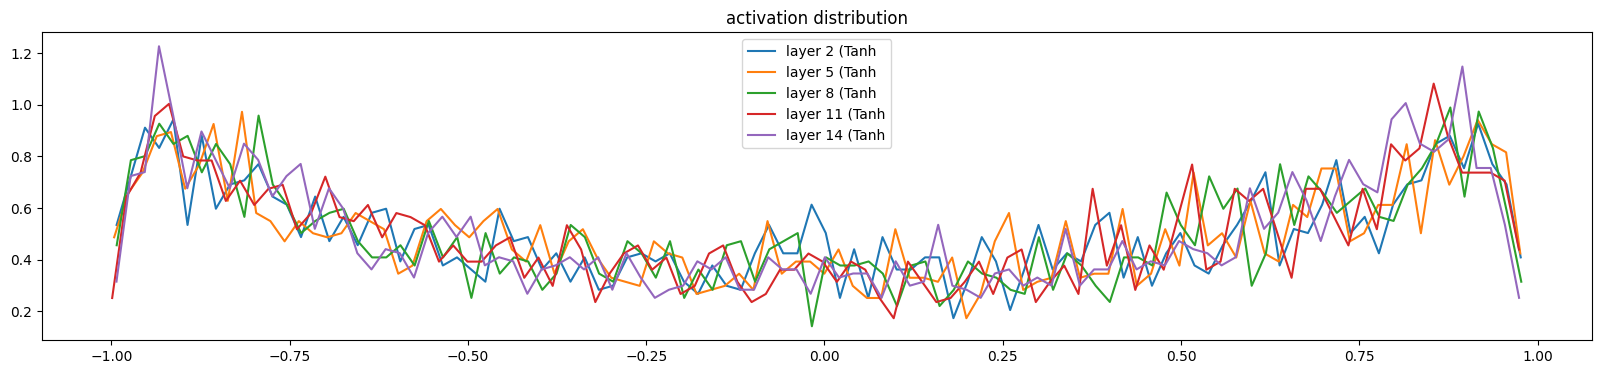

In [125]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

#### Gradient distribution:
Looking for exactly this ditribution of gradient distributions. The scale is not too high or two low s.t the network would be learning in an unstable manner AND there is no diffusion in the later layers. Diffusion would be indicative of a vanishing gradient. Conversely, exploding gradients would also be bad. 

layer 2 (      Tanh): mean +0.000000, std 3.117992e-03
layer 5 (      Tanh): mean -0.000000, std 2.528797e-03
layer 8 (      Tanh): mean +0.000000, std 2.317136e-03
layer 11 (      Tanh): mean +0.000000, std 2.106393e-03
layer 14 (      Tanh): mean +0.000000, std 2.026949e-03


Text(0.5, 1.0, 'gradient distribution')

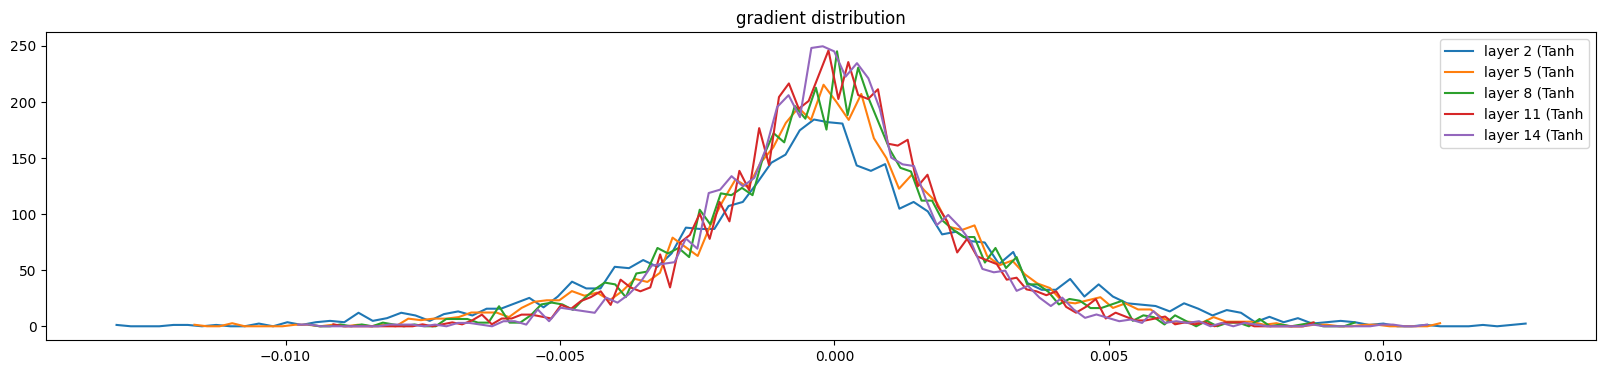

In [126]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

#### Weights gradient distribution:
Looking for exactly this ditribution of weights gradient distributions. As can be seen in the grad:data ratio below, the weights are all being updated at more or less the same rate, except the last layer which is expected as it is a softmax layer. If one layer is significantly larger than the others, then it would mean that the larger ratio'd layer is learning at a significantly larger rate. Although this is indicative, that everything is well tuned, it is better defined in the graph below this one.

weight   (27, 10) | mean -0.000000 | std 1.000441e-02 | grad:data ratio 9.994515e-03
weight  (30, 100) | mean -0.000162 | std 1.097191e-02 | grad:data ratio 5.795947e-02
weight (100, 100) | mean -0.000029 | std 8.503917e-03 | grad:data ratio 8.314789e-02
weight (100, 100) | mean +0.000117 | std 6.979925e-03 | grad:data ratio 6.807298e-02
weight (100, 100) | mean +0.000025 | std 6.375993e-03 | grad:data ratio 6.260220e-02
weight (100, 100) | mean -0.000051 | std 6.253164e-03 | grad:data ratio 6.146755e-02
weight  (100, 27) | mean -0.000062 | std 1.320230e-02 | grad:data ratio 1.269270e-01


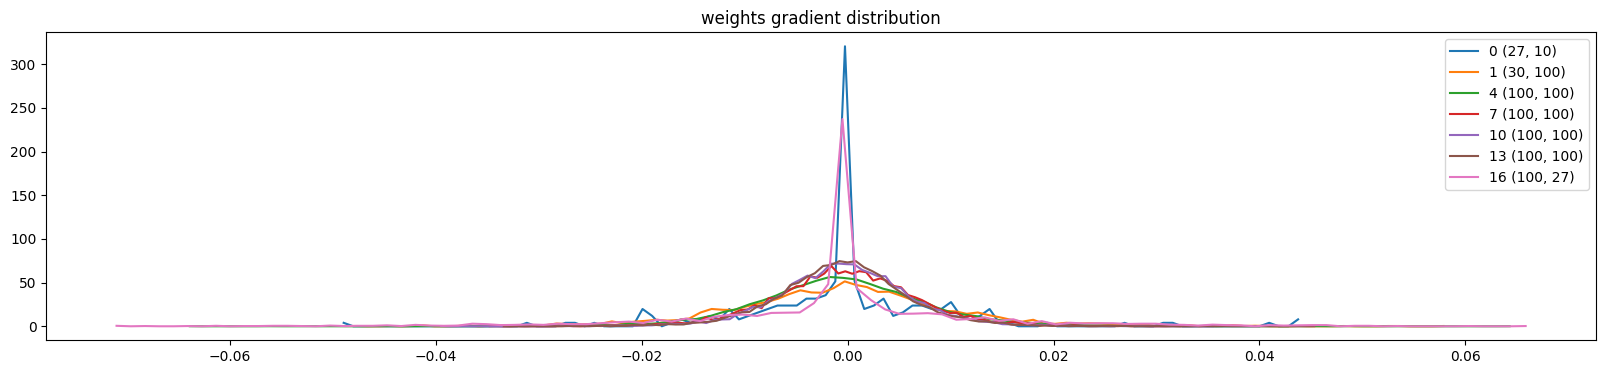

In [127]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

#### Learning Rate relative to the weight:

The graph shows how much these parameters are being updated by realtive to their value. Example: For layer 16 (pink), the values of this layer are being updated by 1e^-2, so if 1 were the value in the layer, then it would be updated by increments of 0.01. Ideally, you would want most of the parameters to be learning at a rate of 1e^-3 whereas here they are learning closer to 1e^-2.5 which isn't bad. 

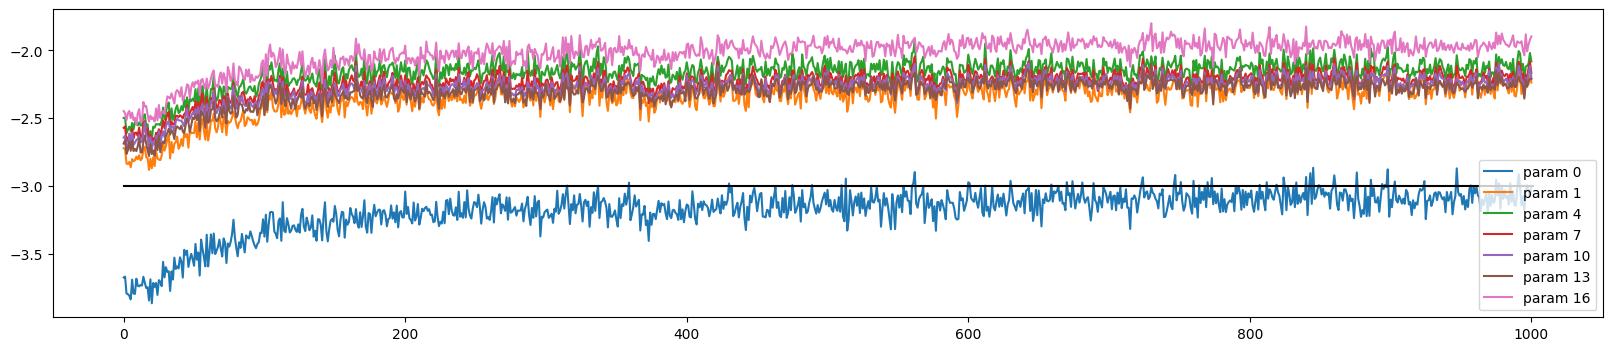

In [128]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
